<a href="https://colab.research.google.com/github/imdrones3/FIT3179/blob/main/Predictive_Model_MSIMUT_vs_MSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory

# you need to create and login to your own Kaggle account, then copy paste the API file for your account
!echo '{"username":"robertzhong","key":"c3447c9d00d7894b926f7c877f6061d6"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

In [ ]:
# Searching for the relevant MSI vs MSS dataset on Kaggle
!kaggle datasets list -s {joangibert/tcga_coad_msi_mss_jpg}

In [ ]:
# Downloading the MSI vs MSS dataset straight from Kaggle
!kaggle datasets download -d joangibert/tcga_coad_msi_mss_jpg -p /content/kaggle/

In [ ]:
# Unzip raw dataset into virtual directory
# can stop execution once it tries to unzip coad_msi-mss files (not going to be used)
!unzip /content/kaggle/tcga_coad_msi_mss_jpg.zip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import os
import glob # walking through folder structure & reading images
import random # to randomly allocate images to train and test sets
import shutil # allows for operations on files eg copying
import cv2 # library used to solve computer vision problems
# eg cv2.imread() loads an image from the specified file

In [ ]:
os.getcwd() # provides current working directory

'/content'

In [ ]:
##################### DATA DIRECTORY & STRUCTURE #############################

# 192,312 unique image patches
# 70% training = 134,618 images  (67,309 MSIMUT & 67,309 MSS images)
# 15% validation = 28,847 images ( 3,865 MSIMUT & 24,982 MSS images)
# 15% test = 28,847 images       ( 3,865 MSIMUT & 24,982 MSS images)
 
if os.path.isdir('train/MSIMUT') is False:
    os.makedirs('train/MSIMUT')
    os.makedirs('train/MSS')
    os.makedirs('validation/MSIMUT')
    os.makedirs('validation/MSS')
    os.makedirs('test/MSIMUT')
    os.makedirs('test/MSS')
            
    # 67,309 MSIMUT training images
    for i in random.sample(glob.glob('MSIMUT_JPEG/*.jpg'), 67309):
        shutil.move(i, 'train/MSIMUT')
        
    # 67,309 MSS training images
    for i in random.sample(glob.glob('MSS_JPEG/*.jpg'), 67309):
        shutil.move(i, 'train/MSS')
        
    # 3,865 MSIMUT validation images
    for i in random.sample(glob.glob('MSIMUT_JPEG/*.jpg'), 3865):
        shutil.move(i, 'validation/MSIMUT')
        
    # 24,982 MSS validation images
    for i in random.sample(glob.glob('MSS_JPEG/*.jpg'), 24982):
        shutil.move(i, 'validation/MSS')
        
    # 3,865 MSIMUT testing images
    for i in random.sample(glob.glob('MSIMUT_JPEG/*.jpg'), 3865):
        shutil.move(i, 'test/MSIMUT')
        
    # 24,982 MSS testing images
    for i in random.sample(glob.glob('MSS_JPEG/*.jpg'), 24982):
        shutil.move(i, 'test/MSS')

In [ ]:
##################### IMAGE PRE-PROCESSING ####################################
train_dir = "train"
validation_dir = "validation"
test_dir = "test"
BATCH_SIZE = 32 


# will generate batches of image data from training folder
train_gen = ImageDataGenerator(rescale=1/255).flow_from_directory(train_dir, 
                                                                  batch_size = BATCH_SIZE,
                                                                  class_mode = 'binary',
                                                                  target_size = (224,224),
                                                                  color_mode = 'rgb',
                                                                  seed=123)

# will generate batches of image data from training folder
validation_gen = ImageDataGenerator(rescale=1/255).flow_from_directory(validation_dir, 
                                                                  batch_size = BATCH_SIZE,
                                                                  class_mode = 'binary',
                                                                  target_size = (224,224),
                                                                  color_mode = 'rgb',
                                                                  seed=123)

# will generate batches of image data from testing folder
test_gen = ImageDataGenerator(rescale=1/255).flow_from_directory(test_dir, 
                                                                  batch_size = BATCH_SIZE, 
                                                                  class_mode='binary', 
                                                                  target_size = (224,224), 
                                                                  color_mode = 'rgb',
                                                                  seed=123,
                                                                  shuffle=False)

Found 134618 images belonging to 2 classes.
Found 28847 images belonging to 2 classes.
Found 28847 images belonging to 2 classes.


In [ ]:
##################### TRAINING - MobileNetV2 ##################################################

EPOCHS = 5
TRAIN_SIZE = 134618
VALIDATION_SIZE = 28847

# Transfer learning using MobileNetV2 architecture, with pre-trained weights on Imagenet
# this only includes the feature extractor component (ie excludes fully-connected layer)
MobileNetV2_model = tf.keras.applications.MobileNetV2(
    weights = "imagenet",
    include_top = False,
    input_shape = (224,224,3)
    )

# Setting layers as False, as we want to use pre-trained weights
for layer in MobileNetV2_model.layers:
    layer.trainable = False
MobileNetV2_model.summary()


# we now add classification layer to MobileNetV2 feature extractor
# we are using sigmoid activation because this is 2-class classification (MSI vs MSS)
# the output dense layer is set to 1, as we are using sigmoid activation function and binary cross entropy loss
model = tf.keras.models.Sequential([MobileNetV2_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dense(1, activation='sigmoid')
])
model.summary()



model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.00001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(train_gen,
          steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
          validation_data = validation_gen,
          validation_steps = VALIDATION_SIZE // BATCH_SIZE,
          epochs = EPOCHS,
          verbose = 1)




# save model as a folder in directory
# can re-load model using keras.models.load_model('MobileNetV2_Model')
# model.save('MobileNetV2_Model')

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

902/902 [==============================] - 65s 72ms/step
Normalized confusion matrix
[[0.76455369 0.23544631]
 [0.22692338 0.77307662]]


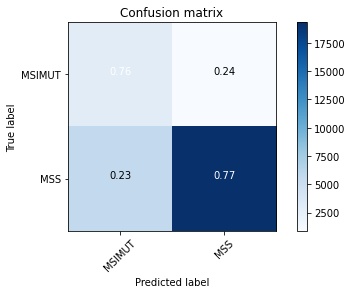

In [ ]:
# directly copied from scikit-learn
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
# we slightly changed the code by setting cm[i, j] to format(cm[i, j], '.2f'), so that normalised confusion matrix is set to 2 decimal places only
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##################### TESTING - MobileNetV2 ##################################################

# will be an array of 28,847 of prediction probabilities between 0 and 1
# np.round(predictions) will show a MSS class prediction if probability > 50%, or MSI prediction if probability < 50%
predictions = model.predict(test_gen, verbose = 1)
predicted_classes = np.round(predictions)
true_classes = test_gen.classes

# plots confusion matrix comparing predicted_classes vs true_classes
cm = confusion_matrix(y_true = true_classes, y_pred = predicted_classes)
test_gen.class_indices # to check which index the labels MSI & MSS are mapped to
cm_plot_labels = ['MSIMUT', 'MSS'] # sensitive to ordering of indices 0 and 1
plot_confusion_matrix(cm=cm, classes = cm_plot_labels)

In [ ]:
##################### TRAINING - VGG16 ##################################################

EPOCHS = 5
TRAIN_SIZE = 134618
VALIDATION_SIZE = 28847

VGG_model = tf.keras.applications.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (224,224,3)
    )

for layer in VGG_model.layers:
    layer.trainable = False

#VGG_model.summary()

model = tf.keras.models.Sequential([VGG_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dense(1, activation='sigmoid')
])
model.summary()


model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.00001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(train_gen,
          steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
          validation_data = validation_gen,
          validation_steps = VALIDATION_SIZE // BATCH_SIZE,
          epochs = EPOCHS,
          verbose = 1)

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 25088)             0         
_________________________________________________________________
module_wrapper_7 (ModuleWrap (None, 256)               6422784   
_________________________________________________________________
module_wrapper_8 (ModuleWrap (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/5
4206/4206 [==============================] - 700s 165ms/step - loss: 0.6220 - accuracy: 0.6486 - val_loss: 0.5092 - val_accuracy: 0.7724
Epoch 2/5
4206/4206 

902/902 [==============================] - 125s 138ms/step
Normalized confusion matrix
[[0.72341527 0.27658473]
 [0.31502682 0.68497318]]


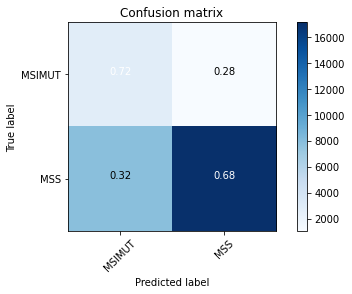

In [ ]:
# directly copied from scikit-learn
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
# we slightly changed the code by setting cm[i, j] to format(cm[i, j], '.2f'), so that normalised confusion matrix is set to 2 decimal places only
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##################### TESTING - VGG16 ##################################################

# will be an array of 28,847 of prediction probabilities between 0 and 1
# np.round(predictions) will show a MSS class prediction if probability > 50%, or MSI prediction if probability < 50%
predictions = model.predict(test_gen, verbose = 1)
predicted_classes = np.round(predictions)
true_classes = test_gen.classes

# plots confusion matrix comparing predicted_classes vs true_classes
cm = confusion_matrix(y_true = true_classes, y_pred = predicted_classes)
test_gen.class_indices # to check which index the labels MSI & MSS are mapped to
cm_plot_labels = ['MSIMUT', 'MSS'] # sensitive to ordering of indices 0 and 1
plot_confusion_matrix(cm=cm, classes = cm_plot_labels)

In [ ]:
##################### TRAINING - Resnet50 ##################################################

EPOCHS = 5
TRAIN_SIZE = 134618
VALIDATION_SIZE = 28847

resnet_model = tf.keras.applications.ResNet50(
    weights = "imagenet",
    include_top = False,
    input_shape = (224,224,3)
    )

for layer in resnet_model.layers:
    layer.trainable = False


model = tf.keras.models.Sequential([resnet_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dense(1, activation='sigmoid')
])
model.summary()


model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.00001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(train_gen,
          steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
          validation_data = validation_gen,
          validation_steps = VALIDATION_SIZE // BATCH_SIZE,
          epochs = EPOCHS,
          verbose = 1)

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 100352)            0         
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 256)               25690368  
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 1)                 257       
Total params: 49,278,337
Trainable params: 25,690,625
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/5
4206/4206 [==============================] - 572s 135ms/step - loss: 0.6985 - accuracy: 0.5292 - val_loss: 0.6200 - val_accuracy: 0.7603
Epoch 2/5
4206/4206

902/902 [==============================] - 94s 104ms/step
Normalized confusion matrix
[[0.42199224 0.57800776]
 [0.26823313 0.73176687]]


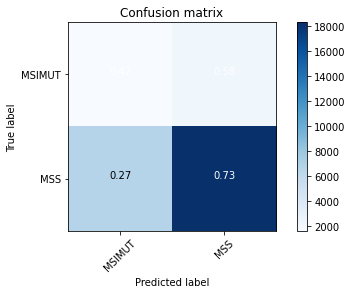

In [ ]:
# directly copied from scikit-learn
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
# we slightly changed the code by setting cm[i, j] to format(cm[i, j], '.2f'), so that normalised confusion matrix is set to 2 decimal places only
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##################### TESTING - Resnet50 ##################################################

# will be an array of 28,847 of prediction probabilities between 0 and 1
# np.round(predictions) will show a MSS class prediction if probability > 50%, or MSI prediction if probability < 50%
predictions = model.predict(test_gen, verbose = 1)
predicted_classes = np.round(predictions)
true_classes = test_gen.classes

# plots confusion matrix comparing predicted_classes vs true_classes
cm = confusion_matrix(y_true = true_classes, y_pred = predicted_classes)
test_gen.class_indices # to check which index the labels MSI & MSS are mapped to
cm_plot_labels = ['MSIMUT', 'MSS'] # sensitive to ordering of indices 0 and 1
plot_confusion_matrix(cm=cm, classes = cm_plot_labels)